# Bootleneck V.4 (Análisis por día, hr Chile continental -04:00:00)

Después de haber entregado el análisis preliminar al cliente, en donde encontramos los valores del __flujo promedio limpio__ (en camiones por hora) para cada zona operacional, es momento de dar un vuelco y comenzar a procesar los datos conforme a encontrar patrones o indicadores de cuellos de botella dentro de CS. Para ello tomaremos la siguiente estructura.

1. Estructuración de los datos.
2. Calculo de estadísticos
3. Representación de estos. 

---

Para entender mejor la estructuración de los datos es necesario comprender ciertos objetivos y conceptos.

__Objetivo Principal__: Comprender el funcionamiento de la faena CS a través del análisis de los tiempos de espera y atención para cada Zona Operacional (ZO)

__Estrategia__: Buscar información en bloques de 30 minutos.

Tendremos 3 tipos de estatus:
1. Atención: cuando un camión se encuentra dentro de una ZO
2. Espera: cuando un camión está en espera o tránsito a una ZO
3. Out: Cuando el camión se encuentra fuera de la faena CS

Qué pretendemos encontrar en cada bloque establecido, para Atención y Espera?
1. N° de camiones que ingresaron y salieron de una ZO
2. N° de camiones que estaban en una ZO al inicio del bloque.
3. Tiempo acumulado de atención (SUM_i (t_i) = Tiempo acumulado).
4. Promedio, moda, media, max, min de tiempos de atención
5. Promedio, moda, media, max, min en el conteo de vehículos en Espera y Atención.

__Conceptos importantes__

1. __Tiempos de IDLE__: cuando tenemos una ZO inactiva y sin camiones en espera
2. __Tiempos de inactividad__: cuando tenemos una ZO inactiva y con camiones en espera
3. __Tiempos de Transición__: corresponden a los tiempos de salida y llegada de camiones (se estima que el máximo debe ser 5 min).


---

# 1. Estructuración de los datos 

Tomaremos en consideración los filtros aplicados en la sección de preprocesado, sin embargo añadiremos nuevas columnas omitidas en ese análisis, como lo son las columnas de "ZO Pre-Time", "ZO start", "ZO end" y quizás otra que consideremos importante para estos propósitos. 

Además,no eliminamos los viajes que van desde CS a CS, es decir los camiones que se encuentran en la misma faena todo el tiempo, debido a que se puede que sean partícipes del cuello de botella generado.

En esta oportunidad no nos enfocaremos en rutas en particular, solamente en las fechas de cada evento. Para ello utilizaremos los tiempos dados por Zone Start y Zone End. Además, despreciaremos las columnas de hora de entrada, hora salida, año entrada, año salida.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import seaborn as sns

In [2]:
df = pd.read_csv("BoottleNeck_filtered_v2.csv", engine='python')
df = df.drop("Unnamed: 0",axis=1)

cols = ['Year [Out]','Month [In]','Month [Out]','Day [In]','Day [Out]','Hour [In]','Hour [Out]']

#Convertimos Zone start y end en .time (hh:mm:ss)
for i in range(1,99):
    zone_1 = "Zone Start (%s)"%i
    zone_2 = "Zone End (%s)"%i
    df[zone_1] = pd.to_datetime(df[zone_1], utc = True).dt.tz_convert('Chile/Continental').dt.time
    df[zone_2] = pd.to_datetime(df[zone_2], utc = True).dt.tz_convert('Chile/Continental').dt.time
df["Date [In]"] = df['Year [In]'].astype(str) + "-" + df["Month [In]"].astype(str) + "-" + df["Day [In]"].astype(str)+" "+df['Hour [In]'].astype(str)+":00:00"
df["Date [In]"] = pd.to_datetime(df["Date [In]"],utc = True)
df["Date [Out]"] = df['Year [Out]'].astype(str) + "-" + df["Month [Out]"].astype(str) + "-" + df["Day [Out]"].astype(str)+" "+df['Hour [Out]'].astype(str)+":00:00"
df["Date [Out]"] = pd.to_datetime(df["Date [Out]"],utc = True)
#convertimos utc a Chile/Continental
df['Date [In]']=pd.to_datetime(df['Date [In]'], utc = True).dt.tz_convert('Chile/Continental')
df["Date [Out]"] = pd.to_datetime(df["Date [Out]"],utc = True).dt.tz_convert('Chile/Continental')

df['Day of year [In]']=pd.to_datetime(df['Date [In]']).dt.dayofyear
df['Day of year [Out]']=pd.to_datetime(df['Date [Out]']).dt.dayofyear

#Dejamos Date [In] como estaba
df["Date [In]"] = pd.to_datetime(df["Date [In]"]).dt.date
df["Date [Out]"] = pd.to_datetime(df["Date [Out]"]).dt.date
df=df.drop(cols,axis=1)
df

Cycle Id  Year [In]            Origin     Destination   Zone Name (1)  \
0      10242520       2019          Coya Sur       Tocopilla  Romana Salitre   
1      10242540       2019         Tocopilla        Coya Sur    C Secado L-4   
2      10527578       2019          Coya Sur        Coya Sur  Romana Salitre   
3       9250786       2019          Coya Sur  Nueva Victoria           C PTS   
4       8143041       2019          Coya Sur  Nueva Victoria          C NPT3   
...         ...        ...               ...             ...             ...   
95249  18633231       2020    Nueva Victoria        Coya Sur             NaN   
95250  18633167       2020          Coya Sur   Virtual_Place          C NPT3   
95251  18633133       2020    Nueva Victoria        Coya Sur             NaN   
95252  18633510       2020  Salar de Atacama        Coya Sur          C NPT3   
95253  18633550       2020  Salar de Atacama        Coya Sur          C NPT3   

       Zone Pre Time (1) Zone Start (1) Zone End (1)  Zone Time (1)  \
0                  249.0       11:30:58     11:35:06          248.0   
1                 5664.0       17:28:39     17:35:53          434.0   
2                    0.0       19:59:34     20:06:35          421.0   
3                    0.0       20:00:09     20:05:52          343.0   
4                  601.0       20:41:50     20:46:50          300.0   
...                  ...            ...          ...            ...   
95249                NaN            NaT          NaT            NaN   
95250              760.0       01:45:18     01:54:19          541.0   
95251                NaN            NaT          NaT            NaN   
95252              715.0       01:46:43     01:53:46          423.0   
95253             1175.0       01:55:39     02:01:05          326.0   

        Zone Name (2)  ...  Zone Time (97) Zone Name (98) Zone Pre Time (98)  \
0        C Secado L-4  ...             NaN            NaN                NaN   
1      Romana Salitre  ...             NaN            NaN                NaN   
2              Salida  ...             NaN            NaN                NaN   
3              Salida  ...             NaN            NaN                NaN   
4              Salida  ...             NaN            NaN                NaN   
...               ...  ...             ...            ...                ...   
95249             NaN  ...             NaN            NaN                NaN   
95250          Salida  ...             NaN            NaN                NaN   
95251             NaN  ...             NaN            NaN                NaN   
95252          Salida  ...             NaN            NaN                NaN   
95253          Salida  ...             NaN            NaN                NaN   

       Zone Start (98) Zone End (98)  Zone Time (98)   Date [In]  Date [Out]  \
0                  NaT           NaT             NaN  2019-06-30  2019-06-30   
1                  NaT           NaT             NaN  2019-06-30  2019-06-30   
2                  NaT           NaT             NaN  2019-06-30  2019-06-30   
3                  NaT           NaT             NaN  2019-06-30  2019-06-30   
4                  NaT           NaT             NaN  2019-06-30  2019-06-30   
...                ...           ...             ...         ...         ...   
95249              NaT           NaT             NaN  2020-06-08  2020-06-08   
95250              NaT           NaT             NaN  2020-06-08  2020-06-08   
95251              NaT           NaT             NaN  2020-06-08  2020-06-08   
95252              NaT           NaT             NaN  2020-06-08  2020-06-08   
95253              NaT           NaT             NaN  2020-06-08  2020-06-08   

       Day of year [In] Day of year [Out]  
0                   181               181  
1                   181               181  
2                   181               181  
3                   181               181  
4                   181               181  
...    

La idea ahora es filtrar por horarios, es decir tener 48 bloques de media hora cada uno, es decir solo veremos las zonas que presentan entradas dentro de ese bloque, además ya no habrá distinción por número de zona, solo nos importará el nombre de ese lugar y sus datos.

In [3]:
def block_generator(dia_inicio,dia_fin,inicio,fin,condition='in'):
    """Entregamos un Año, mes, día  y el rango de horas entre las cuales se quiere tener el bloque, 
       hr:min:seg > block >hr_:min_:seg_ """
    cont = 0
    for i in range(1,99):
        zone_1 = "Zone Name (%s)"%i
        zone_2 = "Zone Pre Time (%s)"%i
        zone_3 = "Zone Start (%s)"%i
        zone_4 = "Zone End (%s)"%i
        zone_5 = "Zone Time (%s)"%i

        cols=['Cycle Id', 'Origin', 'Destination','Date [In]','Date [Out]','Day of year [In]','Day of year [Out]',
              zone_1, zone_2, zone_3, zone_4, zone_5]

        date_lower = datetime.time(inicio[0], inicio[1], inicio[2])
        date_upper = datetime.time(fin[0], fin[1], fin[2])
        
        if (condition == 'in'):
            a = df[(df[zone_3] < date_upper) & (df[zone_3] >= date_lower) & (df['Day of year [In]'] >= dia_inicio) & (df['Day of year [In]'] <= dia_fin)] 
        elif (condition == 'out'):
            a = df[(df[zone_4] < date_upper) & (df[zone_4] >= date_lower) & (df['Day of year [Out]'] >= dia_inicio) & (df['Day of year [Out]'] <= dia_fin)]     
        else:
            break
        b = a.loc[:,cols]
        b = b.rename(columns={zone_1:"Name ZO",
                          zone_2:"Pre Time",
                          zone_3:"Start",
                          zone_4:"End",
                          zone_5:"Time"})    
        if cont == 0:
            block = b
            cont += 1
            continue
        else:
            block = pd.concat([block, b], axis=0, sort=False) 
    block = block.sort_values(['Cycle Id', 'Name ZO',"Date [In]"], ascending=[True,True,True])
    return block

__Es importante mencionar que ahora necesitamos introducir el dia del año al query, los días para el año 2019 van desde el 181 (30 de Junio) hasta el 365 (12 de Dic), mientras que para el 220 van  desde el 1 (1 Enero) al 160 (8 de Junio), no se alcanzan a solapar__

In [4]:
inicio = [0,0,0]
fin =  [23,59,59]
Block=block_generator(182,182,inicio,fin,condition='in')
Block[Block["Name ZO"] == "Romana Salitre"].sort_values(['Start'], ascending=[False])

Cycle Id     Origin Destination   Date [In]  Date [Out]  \
202  10242660  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
200   9740998  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
200   9740998  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
193  10659068   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
186   8896124   Coya Sur   Tocopilla  2019-07-01  2019-07-02   
182  10048142  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
187   7914050   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
180  10395033  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
179  10817493   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
182  10048142  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
182  10048142  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
177  10242639  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
175   8946366  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
170  10693991   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
147  10110528   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
149  10658964   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
140   8961069  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
141  10718100   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
149  10658964   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
140   8961069  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
132   8896103   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
130  10527629  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
127  10242604  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
126  10048118  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
124  10817459   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
123   7914007   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
125   8946350  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
121  10693967   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
124  10817459   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
123   7914007   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
121  10693967   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
115  10832759  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
115  10832759  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
111  10110480   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
94    8961044  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
108  10718064   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
108  10718064   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
98    9740978  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
97   10527600  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
98    9740978  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
97   10527600  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
97   10527600  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
47    8896073   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
71    7826733   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
65   10048090  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
67   10817423   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
71    7826733   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
44   10693928   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
44   10693928   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
47    8896073   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
42   10110434   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
42   10110434   Coya Sur   Tocopilla  2019-07-01  2019-07-01   
21   10242576  Tocopilla    Coya Sur  2019-07-01  2019-07-01   
21   10242576  Tocopilla    Coya Sur  2019-07-01  2019-07-01   

     Day of year [In]  Day of year [Out]         Name ZO  Pre Time     Start  \
202               182                182  Romana Salitre     124.0  22:48:48   
200               182                182  Romana Salitre     125.0  22:34:17   
200               182                182  Romana Salitre     249.0  22:12:05   
193               182                182  Romana Salitre     240.0  21:49:26   
186               182                183  Romana Salitre     120.0  20:54:44   
182 

# 2. Cálculo de estadísticos

Buscaremos algunas métricas que nos son importantes para el cliente tales como:

1. N° Vehículos que ingresaron y salieron de la ZO
2. N° Vehículos que estaban en una ZO al inicio
3. Tiempo acumulado de atención
4. Prom, Moda, Max, Min de los tiempos de atención
5. Prom, Max, Min, del conteo de vehículos en espera o atención.

Para realizar esto primero debemos definir los bloques de tiempo en los cuales analizaremos esto,ya sea  por mes, día, hora, minutos,etc.

---

## N° Vehículos que ingresaron y salieron de la ZO

Consideraremos por bloques horario de 1 hr para el día en particular escogido 

In [5]:
#Vehiculos ingresados
def vehiculos(dia_inicio,dia_fin,inicio=1,fin=25,condition='in'):
    """Generamos un diccionario que contenga zona: {bloque hr: vehiculos ingresados} """
    diccionario = {}
    for i in range(inicio,fin):
        start = [i-1,0,0]
        if(i == 24):
            end = [23,59,59]
        else:
            end = [i,0,0]
        if (condition == 'out'):
            df_ = block_generator(dia_inicio,dia_fin,start,end,condition=condition)
            date_lower = datetime.time(start[0], start[1], start[2])
            date_upper = datetime.time(end[0], end[1], end[2])
        elif (condition == 'in'):
            df_ = block_generator(dia_inicio,dia_fin,start,end,condition=condition)
        else:
            break
        for zo in df_['Name ZO'].unique().tolist(): 
            block_filtered = df_[df_['Name ZO'] == zo]
            if (condition == 'out'):
                block_filtered = block_filtered[(block_filtered['End'] < date_upper) & (block_filtered['End'] >= date_lower)]
            vehiculos_in = block_filtered.shape[0]
            if zo == 'Salida':
                continue
            else:
                if zo in diccionario.keys():
                    diccionario[zo].update({i:vehiculos_in})
                else:
                    diccionario.update({zo:{i:vehiculos_in}})
    return diccionario

def vehiculos_time(dia_inicio,dia_fin,inicio=1,fin=25,condition='in',cond='time'):
    """Generamos un diccionario que contenga zona: {bloque hr: vehiculos salieron} """
    diccionario = {}
    for i in range(inicio,fin):
        start = [i-1,0,0]
        if(i == 24):
            end = [23,59,59]
        else:
            end = [i,0,0]
        df_ = block_generator(dia_inicio,dia_fin,start,end,condition=condition)
        date_lower = datetime.time(start[0], start[1], start[2])
        date_upper = datetime.time(end[0], end[1], end[2])
        for zo in df_['Name ZO'].unique().tolist(): 
            block_filtered = df_[df_['Name ZO'] == zo]
            block_filtered = block_filtered[(block_filtered['End'] < date_upper) & (block_filtered['End'] >= date_lower)]
            if(cond=='pre time'):
                cumulative_time = block_filtered['Pre Time'].sum()
            else:
                cumulative_time = block_filtered.Time.sum()
            if zo == 'Salida':
                continue
            else:
                if zo in diccionario.keys():
                    diccionario[zo].update({i:(cumulative_time/60)})
                else:
                     diccionario.update({zo:{i:(cumulative_time/60)}})                
    return diccionario

def dict_to_df(dictionary):
    """ Pasamos de Dicionario a df de la forma que nosotros necesitamos"""
    count=0
    for k, v in dictionary.items():
        a = pd.DataFrame.from_dict(v,'index')
        a = a.rename(columns={a.columns[0]:k})
        if (count == 0):
            b=a
            count +=1
            continue 
        else:
            b=pd.concat([b,a],axis=1)
    b = b.fillna(0)
    return b



In [6]:
zonas_bloques=vehiculos(182,182,1,25,condition="in")
heat_map=dict_to_df(zonas_bloques)

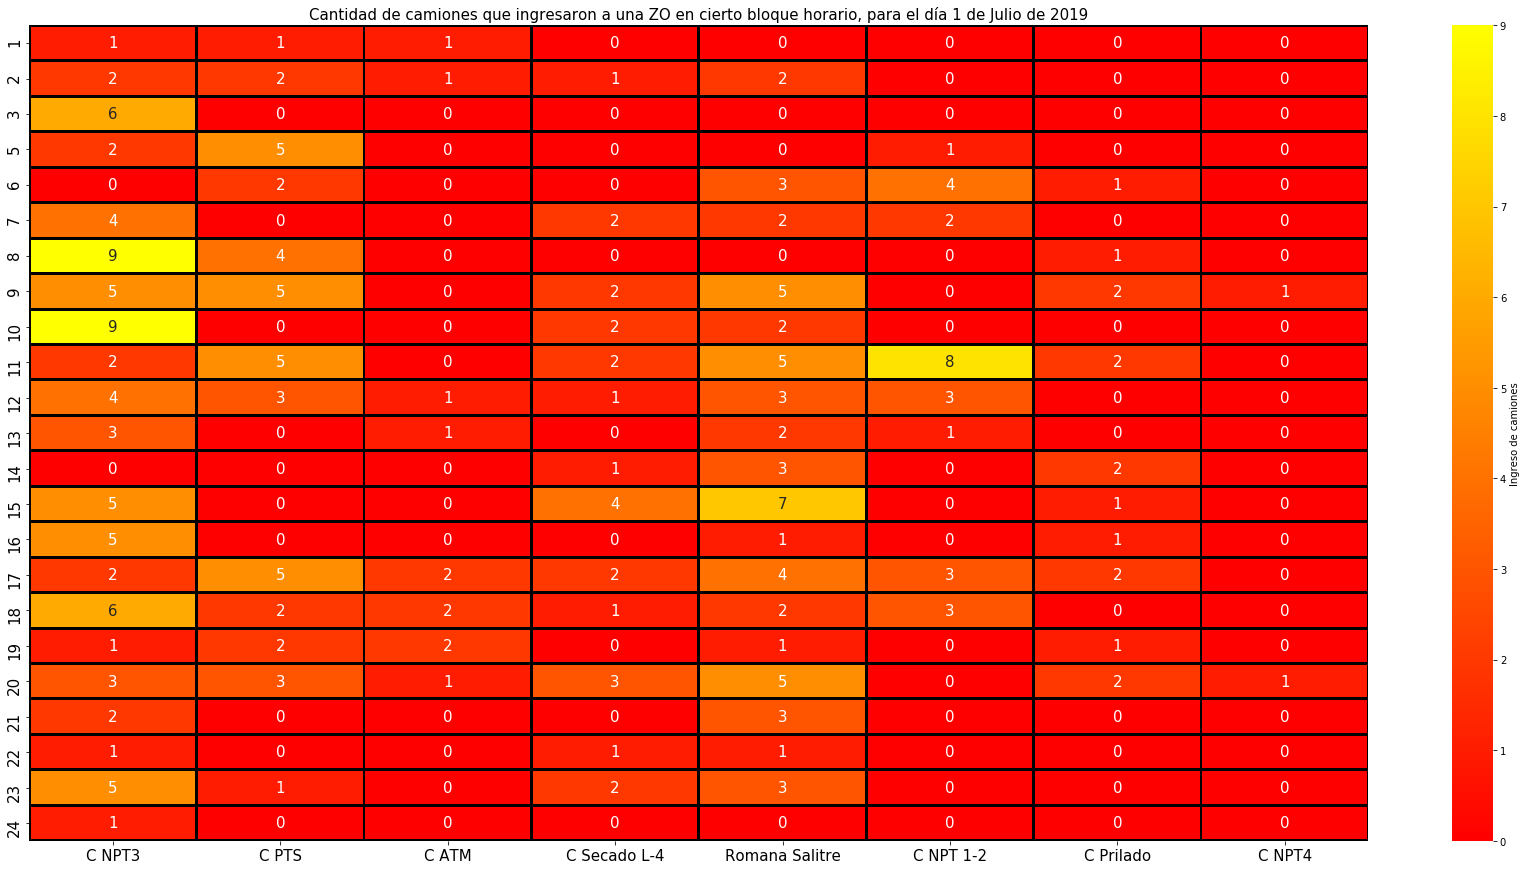

In [7]:
fig, ax = plt.subplots(figsize=(30,15)) 
sns.heatmap(heat_map,cmap="autumn",linecolor="black", linewidths=2,cbar_kws={'label': 'Ingreso de camiones'}, annot=True, fmt=".0f",annot_kws={"size": 15})
plt.tick_params(labelsize=15)
plt.title("Cantidad de camiones que ingresaron a una ZO en cierto bloque horario, para el día 1 de Julio de 2019",fontsize=15)
plt.show()

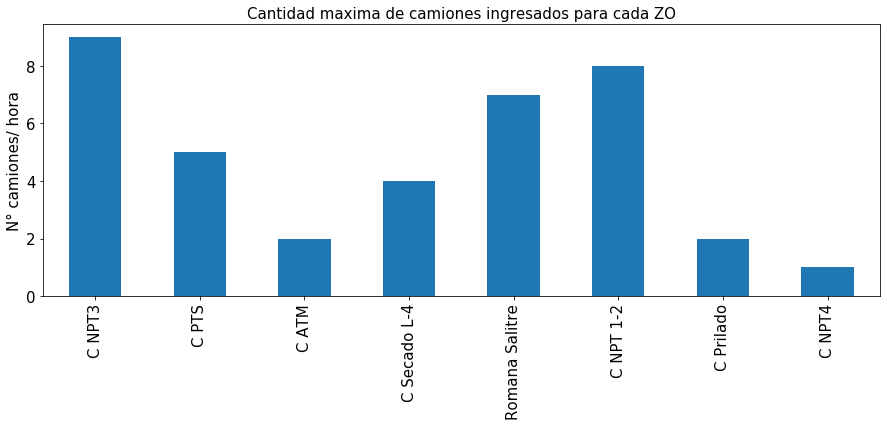

In [8]:
heat_map.max().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Cantidad maxima de camiones ingresados para cada ZO",fontsize=15)
plt.ylabel("N° camiones/ hora",fontsize=15)
plt.show()

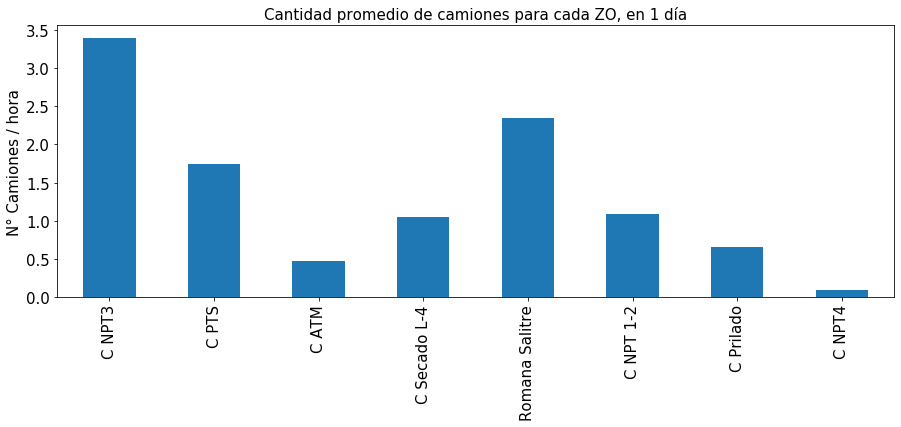

In [9]:
heat_map.mean().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Cantidad promedio de camiones para cada ZO, en 1 día",fontsize=15)
plt.ylabel("N° Camiones / hora",fontsize=15)
plt.show()

In [10]:
zonas_bloques=vehiculos(182,182,1,25,condition="out")
heat_map_out=dict_to_df(zonas_bloques)

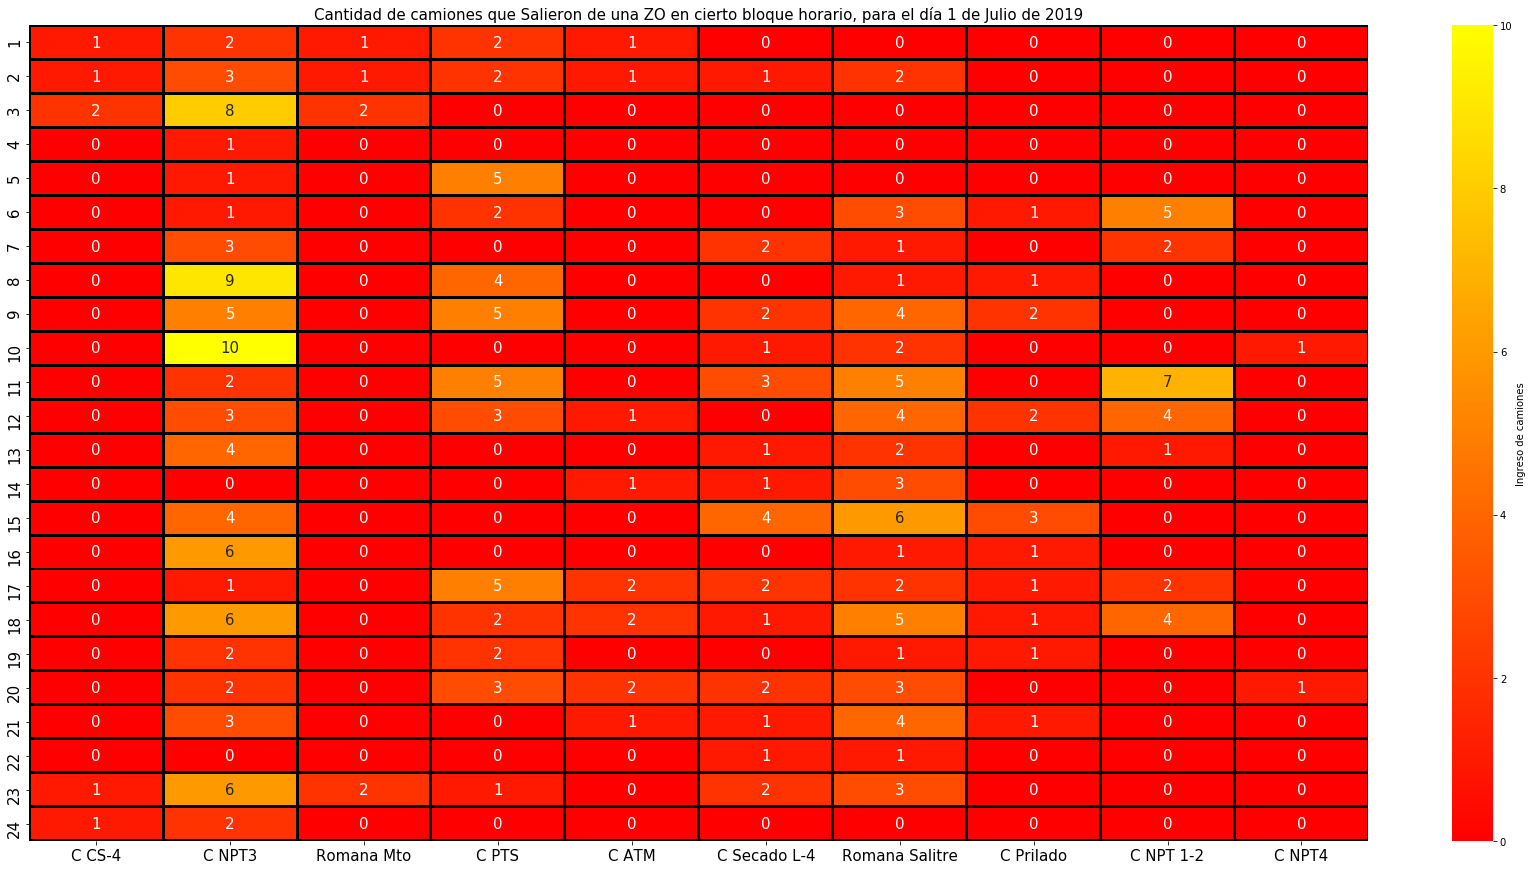

In [11]:
fig, ax = plt.subplots(figsize=(30,15)) 
sns.heatmap(heat_map_out,cmap="autumn",linecolor="black", linewidths=2,cbar_kws={'label': 'Ingreso de camiones'}, annot=True, fmt=".0f",annot_kws={"size": 15})
plt.tick_params(labelsize=15)
plt.title("Cantidad de camiones que Salieron de una ZO en cierto bloque horario, para el día 1 de Julio de 2019",fontsize=15)
plt.show()

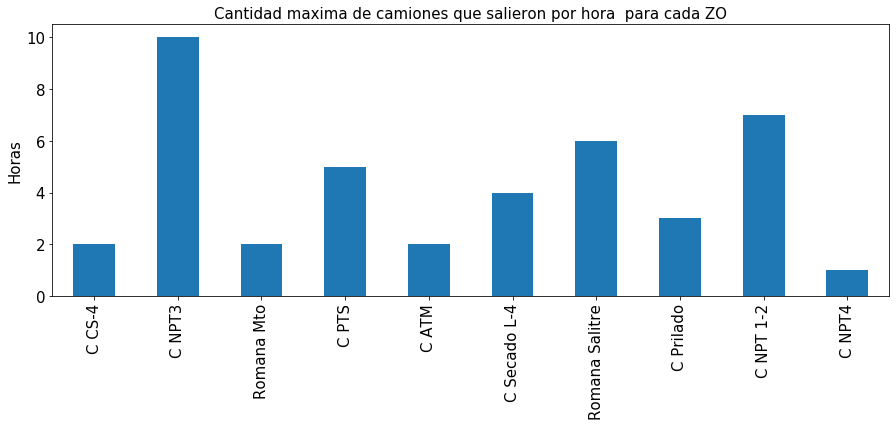

In [12]:
heat_map_out.max().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Cantidad maxima de camiones que salieron por hora  para cada ZO",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()

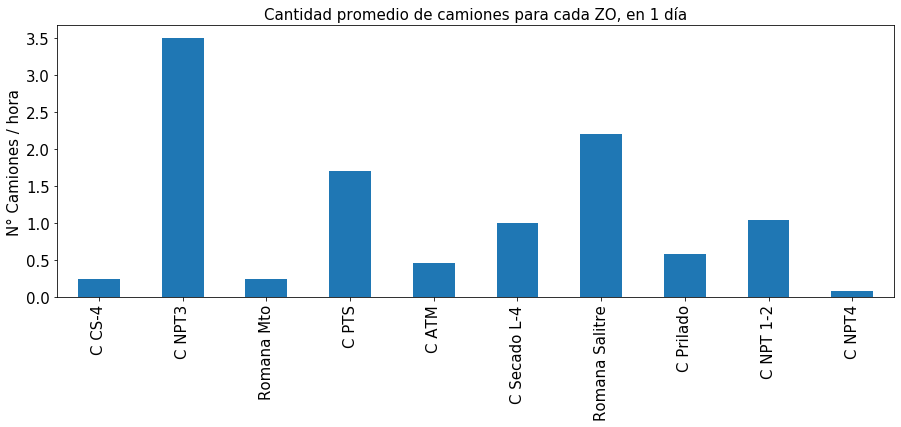

In [13]:
heat_map_out.mean().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Cantidad promedio de camiones para cada ZO, en 1 día",fontsize=15)
plt.ylabel("N° Camiones / hora",fontsize=15)
plt.show()

In [14]:
zonas_bloques=vehiculos_time(182,182,1,25,condition="in",cond='time')
heat_map_time=dict_to_df(zonas_bloques)
heat_map_time

C NPT3      C PTS      C ATM  C Secado L-4  Romana Salitre  C NPT 1-2  \
1    0.000000   9.100000   9.016667      0.000000        0.000000   0.000000   
2    5.716667  10.133333   8.233333      7.233333       11.400000   0.000000   
3   34.883333   0.000000   0.000000      0.000000        0.000000   0.000000   
5    6.050000  22.433333   0.000000      0.000000        0.000000   0.000000   
6    0.000000   8.700000   0.000000      0.000000       20.983333  29.583333   
7   17.933333   0.000000   0.000000     15.033333        7.983333  15.383333   
8   49.216667  24.633333   0.000000      0.000000        0.000000   0.000000   
9   71.266667  26.600000   0.000000     17.333333       45.566667   0.000000   
10  56.983333   0.000000   0.000000     15.200000        2.000000   0.000000   
11   9.000000  25.466667   0.000000     10.166667       22.483333  83.000000   
12  22.466667  15.483333  31.833333      0.000000       24.483333  19.683333   
13  27.416667   0.000000   0.000000      0.000000       14.000000   6.616667   
14   0.000000   0.000000   0.000000      8.983333       31.050000   0.000000   
15  24.000000   0.000000   0.000000     36.783333       64.833333   0.000000   
16  30.933333   0.000000   0.000000      0.000000        0.000000   0.000000   
17   5.900000  24.233333  30.183333     16.983333        7.000000  14.166667   
18  34.000000  11.000000  52.066667     10.016667       23.966667  23.133333   
19  14.033333  12.833333   0.000000      0.000000       11.550000   0.000000   
20  11.000000  16.633333   0.000000      9.266667       15.850000   0.000000   
21  11.000000   0.000000   0.000000      0.000000       25.316667   0.000000   
22   0.000000   0.000000   0.000000     11.000000        8.000000   0.000000   
23  26.050000   5.350000   0.000000     15.416667       19.783333   0.000000   
24   5.000000   0.000000   0.000000      0.000000        0.000000   0.000000   

    C Prilado    C NPT4  
1    0.000000  0.000000  
2    0.000000  0.000000  
3    0.000000  0.000000  
5    0.000000  0.000000  
6    2.000000  0.000000  
7    0.000000  0.000000  
8    4.983333  0.000000  
9   77.700000  0.000000  
10   0.000000  0.000000  
11   0.000000  0.000000  
12   0.000000  0.000000  
13   0.000000  0.000000  
14   0.000000  0.000000  
15  17.766667  0.000000  
16  31.100000  0.000000  
17  37.416667  0.000000  
18   0.000000  0.000000  
19  18.883333  0.000000  
20   0.000000  5.033333  
21   0.000000  0.000000  
22   0.000000  0.000000  
23   0.000000  0.000000  
24   0.000000  0.000000

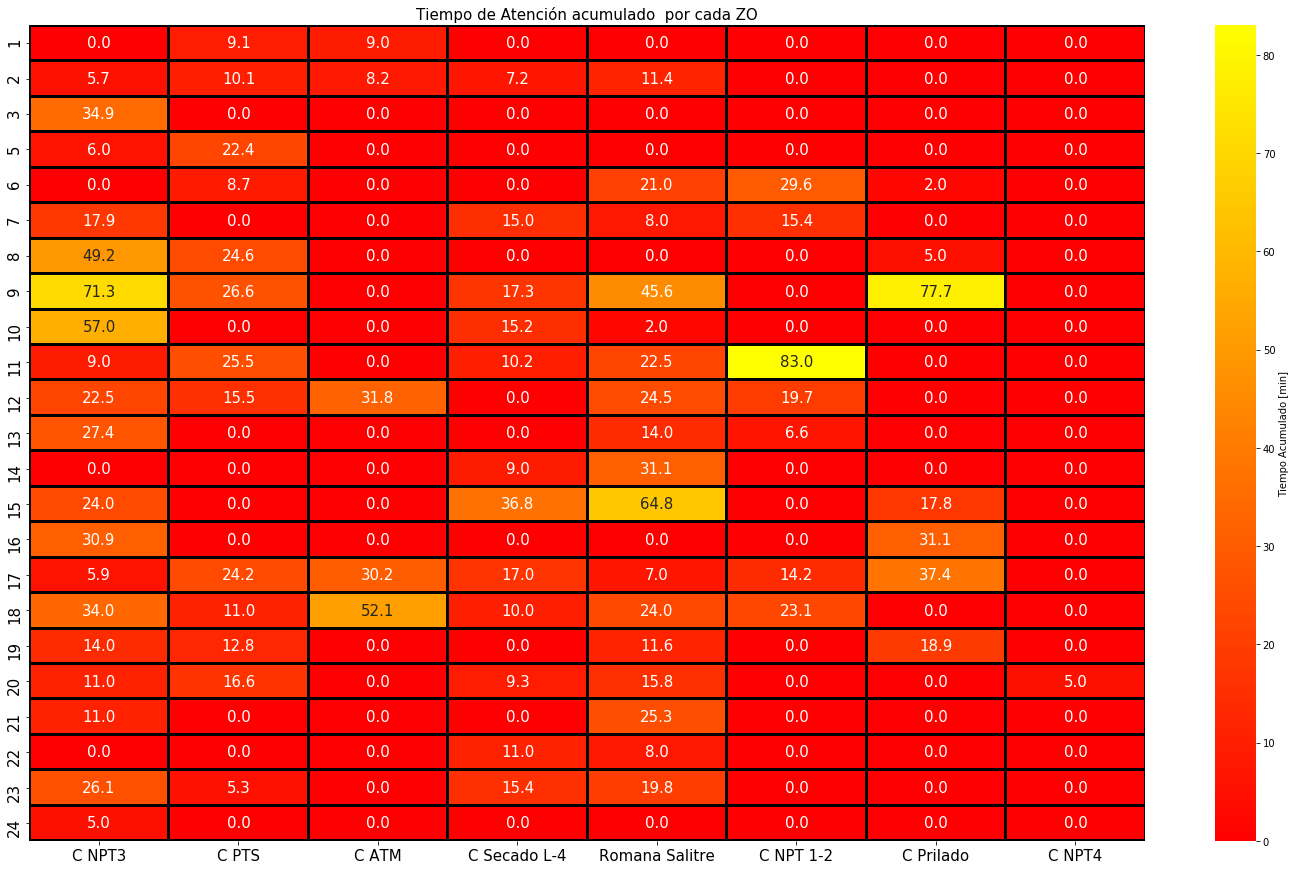

In [15]:
fig, ax = plt.subplots(figsize=(25,15)) 
sns.heatmap(heat_map_time,cmap="autumn",linecolor="black", linewidths=2,cbar_kws={'label': 'Tiempo Acumulado [min]'},annot=True, fmt=".1f",annot_kws={"size": 15})
plt.title("Tiempo de Atención acumulado  por cada ZO",fontsize=15)
plt.tick_params(labelsize=15)
plt.show()

In [16]:
zonas_bloques=vehiculos_time(182,182,1,25,condition="in",cond='pre time')
heat_map_pretime=dict_to_df(zonas_bloques)

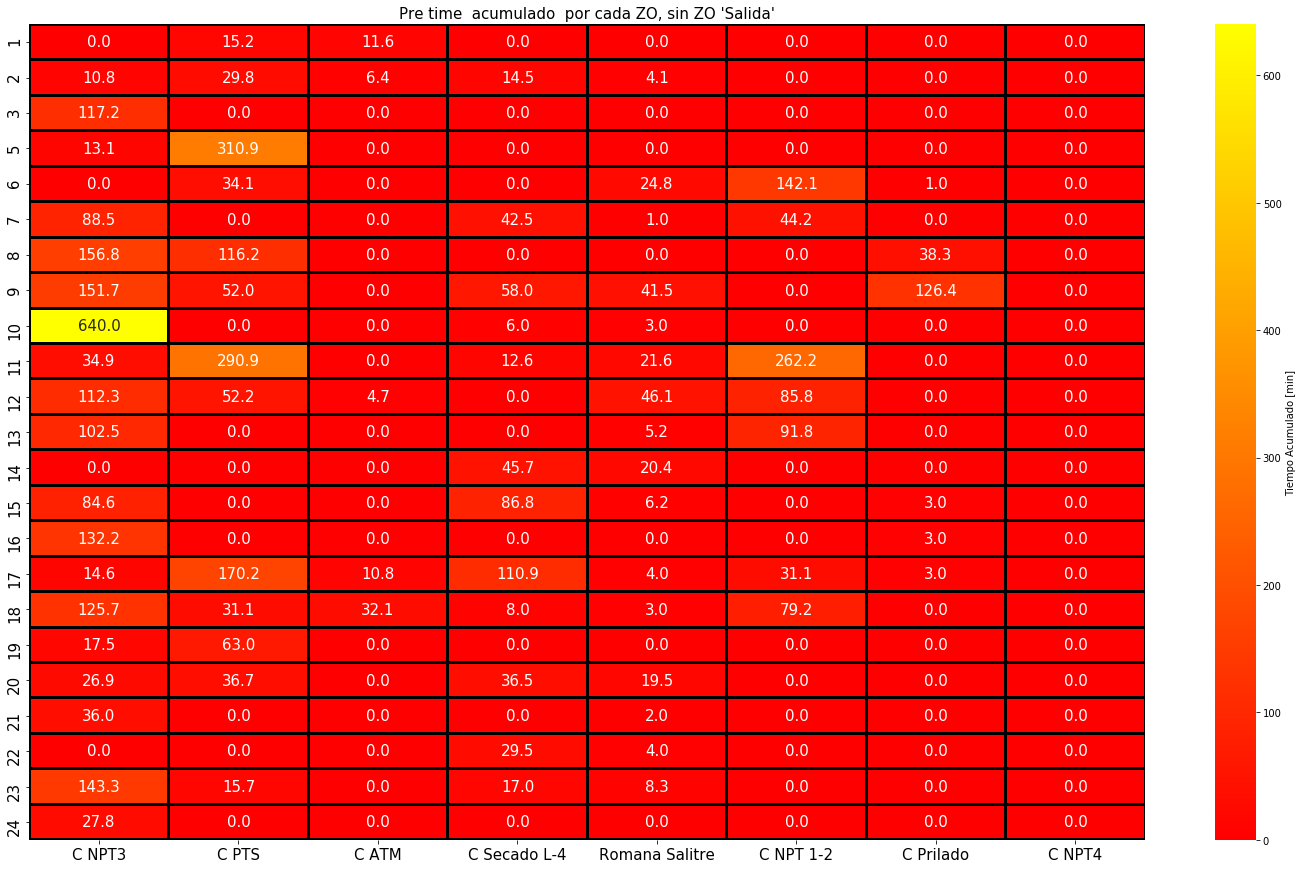

In [17]:
fig, ax = plt.subplots(figsize=(25,15)) 
sns.heatmap(heat_map_pretime,cmap="autumn",linecolor="black", linewidths=2,cbar_kws={'label': 'Tiempo Acumulado [min]'},annot=True, fmt=".1f",annot_kws={"size": 15})
plt.title("Pre time  acumulado  por cada ZO, sin ZO 'Salida'",fontsize=15)
plt.tick_params(labelsize=15)
plt.show()

# Analicemos la primera semana del mes de Julio de 2019

In [18]:
zo_block=vehiculos(182,188,1,25,condition="in")
aux_2=dict_to_df(zo_block)

In [19]:
aux_norm= aux_2/7
aux_norm.describe()

Romana Salitre  C Secado L-4     C NPT3      C PTS  C NPT 1-2  \
count       24.000000     24.000000  24.000000  24.000000  24.000000   
mean         1.934524      0.714286   6.375000   0.297619   0.196429   
std          1.016265      0.519368   2.361257   0.306443   0.325798   
min          0.000000      0.000000   2.142857   0.000000   0.000000   
25%          1.250000      0.392857   4.535714   0.000000   0.000000   
50%          1.857143      0.571429   6.071429   0.285714   0.000000   
75%          2.500000      1.178571   8.107143   0.571429   0.428571   
max          4.571429      1.714286  10.714286   0.857143   1.285714   

       C Granulacion  C Prilado     C CS-4  Romana Mto      C ATM  \
count      24.000000  24.000000  24.000000   24.000000  24.000000   
mean        0.083333   0.434524   0.077381    0.083333   0.523810   
std         0.118529   0.305173   0.111290    0.125792   0.672263   
min         0.000000   0.000000   0.000000    0.000000   0.000000   
25%         0.000000   0.142857   0.000000    0.000000   0.000000   
50%         0.000000   0.357143   0.000000    0.000000   0.142857   
75%         0.142857   0.714286   0.142857    0.142857   1.000000   
max         0.285714   1.000000   0.285714    0.571429   2.428571   

       C Secado L-3  Losa Envasado     C NPT4   Galpones  
count     24.000000      24.000000  24.000000  24.000000  
mean       0.095238       0.214286   0.101190   0.005952  
std        0.161331       0.249222   0.136369   0.029161  
min        0.000000       0.000000   0.000000   0.000000  
25%        0.000000       0.000000   0.000000   0.000000  
50%        0.000000       0.142857   0.000000   0.000000  
75%        0.142857       0.321429   0.178571   0.000000  
max        0.571429       0.857143   0.428571   0.142857

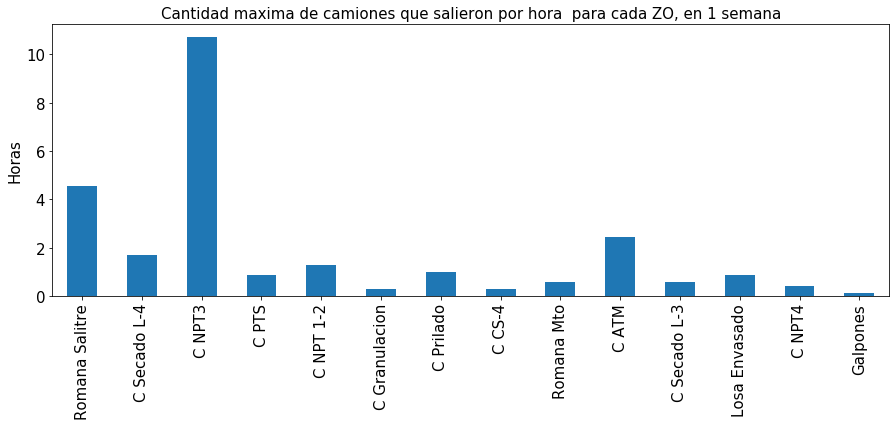

In [26]:
aux_norm.max().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Cantidad maxima de camiones que salieron por hora  para cada ZO, en 1 semana",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()

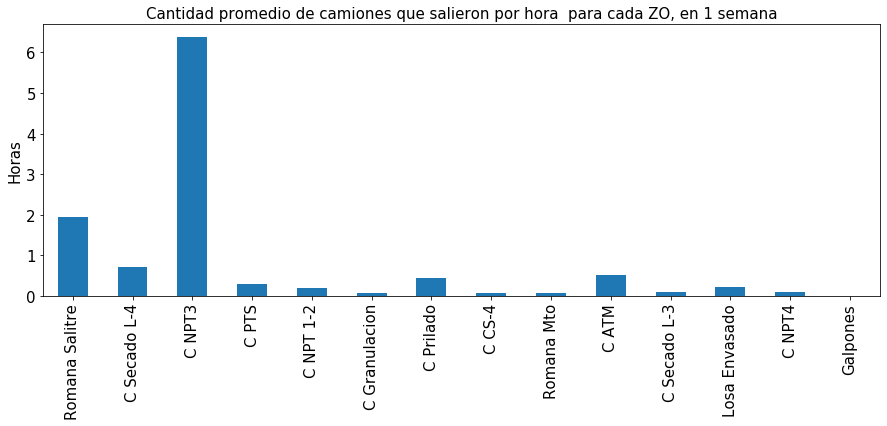

In [27]:
aux_norm.mean().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Cantidad promedio de camiones que salieron por hora  para cada ZO, en 1 semana",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()

# Analicemos el mes de Julio de 2019

In [28]:
step = 31 #31 dias tiene Julio
dia_inicio = 182
dia_fin = dia_inicio+(step-1)
zo_block=vehiculos(dia_inicio,dia_fin,1,25,condition="in")
month=dict_to_df(zo_block)

In [29]:
month_norm=month/31
month_norm.describe()

C Secado L-4  Romana Salitre     C NPT3      C ATM  C NPT 1-2  \
count     24.000000       24.000000  24.000000  24.000000  24.000000   
mean       1.008065        1.974462   6.225806   0.396505   0.577957   
std        0.394535        0.771324   2.215773   0.335570   0.491609   
min        0.225806        0.806452   2.225806   0.032258   0.000000   
25%        0.830645        1.322581   4.870968   0.096774   0.185484   
50%        1.000000        2.000000   6.112903   0.338710   0.403226   
75%        1.233871        2.580645   8.048387   0.645161   1.040323   
max        1.903226        3.483871  10.096774   1.258065   1.548387   

           C PTS  C Granulacion  C Prilado     C CS-4  Romana Mto  \
count  24.000000      24.000000  24.000000  24.000000   24.000000   
mean    0.434140       0.108871   0.267473   0.100806    0.092742   
std     0.271225       0.096920   0.206767   0.102147    0.112275   
min     0.000000       0.000000   0.000000   0.000000    0.000000   
25%     0.274194       0.032258   0.096774   0.024194    0.024194   
50%     0.403226       0.064516   0.241935   0.064516    0.032258   
75%     0.588710       0.193548   0.403226   0.193548    0.169355   
max     0.967742       0.322581   0.806452   0.322581    0.419355   

       C Secado L-3     C NPT4  Losa Envasado    C CS-11   Galpones  
count     24.000000  24.000000      24.000000  24.000000  24.000000  
mean       0.040323   0.038978       0.086022   0.033602   0.001344  
std        0.061094   0.035566       0.093525   0.046093   0.006585  
min        0.000000   0.000000       0.000000   0.000000   0.000000  
25%        0.000000   0.000000       0.000000   0.000000   0.000000  
50%        0.016129   0.032258       0.048387   0.000000   0.000000  
75%        0.064516   0.064516       0.129032   0.064516   0.000000  
max        0.225806   0.096774       0.354839   0.129032   0.032258

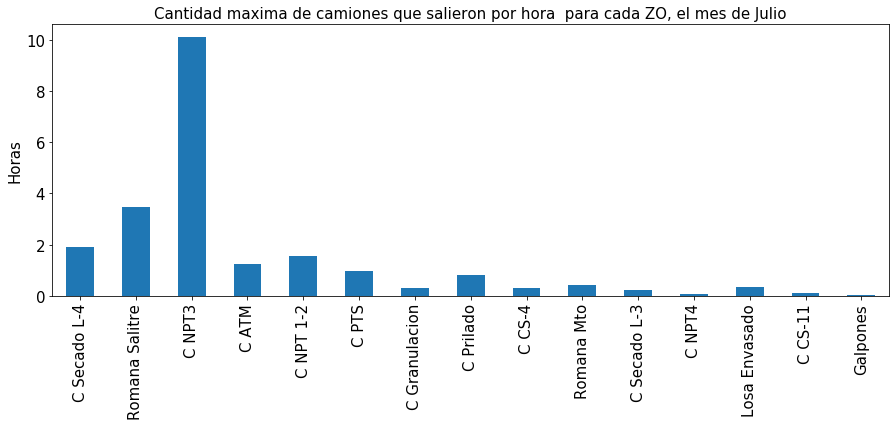

In [30]:
month_norm.max().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Cantidad maxima de camiones que salieron por hora  para cada ZO, el mes de Julio",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()

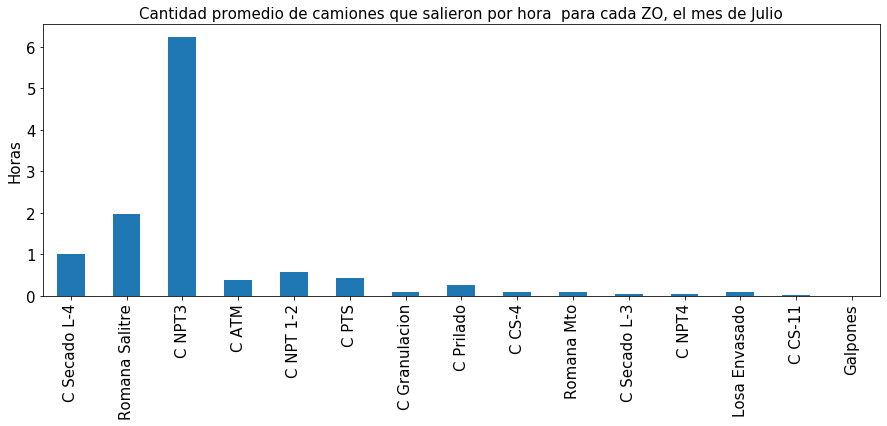

In [31]:
month_norm.mean().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Cantidad promedio de camiones que salieron por hora  para cada ZO, el mes de Julio",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()

# Analicemos el año 2019

In [32]:
dia_inicio = 182
dia_fin = 365
zo_block=vehiculos(dia_inicio,dia_fin,1,25,condition="in")
year=dict_to_df(zo_block)

In [33]:
year_norm=year/(365-182)
year_norm.describe()

C NPT3  C NPT 1-2  C Secado L-4  Romana Salitre     C CS-4  \
count  24.000000  24.000000     24.000000       24.000000  24.000000   
mean    5.629098   0.524818      1.445355        4.469945   1.906648   
std     1.771702   0.259986      0.590368        2.121223   0.498544   
min     2.426230   0.163934      0.530055        1.136612   0.655738   
25%     4.016393   0.263661      0.864754        2.382514   1.688525   
50%     6.166667   0.521858      1.551913        4.606557   1.975410   
75%     7.036885   0.771858      1.844262        6.344262   2.271858   
max     8.087432   0.934426      2.519126        7.579235   2.584699   

       Losa Envasado  C Prilado   Galpones  Romana Mto      C PTS      C ATM  \
count      24.000000  24.000000  24.000000   24.000000  24.000000  24.000000   
mean        0.477004   1.147086   0.263661    0.171448   0.524135   0.453324   
std         0.170057   0.532677   0.159676    0.091861   0.185876   0.312507   
min         0.169399   0.234973   0.032787    0.032787   0.224044   0.021858   
25%         0.336066   0.748634   0.158470    0.102459   0.363388   0.139344   
50%         0.519126   1.125683   0.245902    0.158470   0.524590   0.502732   
75%         0.606557   1.602459   0.390710    0.250000   0.695355   0.758197   
max         0.726776   1.923497   0.601093    0.333333   0.808743   0.972678   

          C NPT4  C CS-P.Valdivia  C Secado L-3  C Granulacion    C CS-12  \
count  24.000000        24.000000     24.000000      24.000000  24.000000   
mean    0.411430         0.012295      0.103825       0.061020   0.003871   
std     0.236493         0.008863      0.053710       0.044002   0.005692   
min     0.071038         0.000000      0.016393       0.000000   0.000000   
25%     0.219945         0.005464      0.066940       0.035519   0.000000   
50%     0.390710         0.013661      0.101093       0.060109   0.000000   
75%     0.521858         0.016393      0.153005       0.077869   0.005464   
max     0.923497         0.027322      0.191257       0.191257   0.021858   

         C CS-11   Romana 3  
count  24.000000  24.000000  
mean    0.006831   0.014572  
std     0.008565   0.016248  
min     0.000000   0.000000  
25%     0.000000   0.000000  
50%     0.000000   0.010929  
75%     0.016393   0.023224  
max     0.021858   0.054645

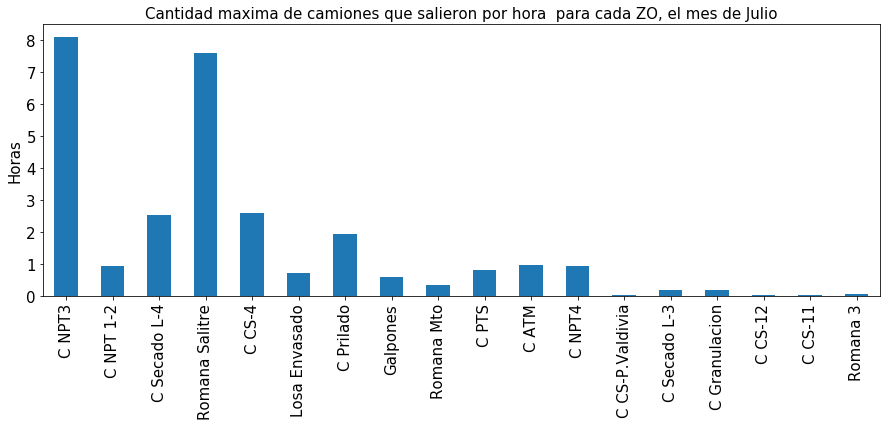

In [34]:
year_norm.max().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Cantidad maxima de camiones que salieron por hora  para cada ZO, el mes de Julio",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()

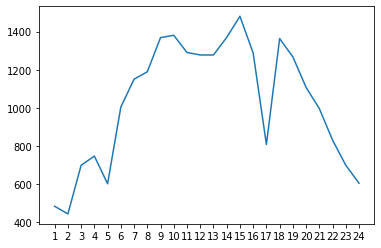

In [35]:
year["C NPT3"].plot(kind="line",xticks=np.arange(1,25,1))

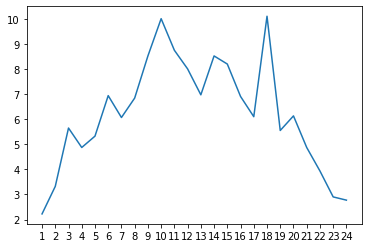

In [36]:
month_norm["C NPT3"].plot(kind="line",xticks=np.arange(1,25,1))

# Visión por Mes

Analizaremos los máximos de cada mes en función de los bloques horarios. y de las salidas de vehículos, para cada ZO por separado

In [21]:
dias_mes = [[1,31],[32,60],[61,91],[92,121],[122,152],[153,160],[182,212],[213,243],[244,273],[274,304],[305,334],[335,365]]
#Enero
Jan = dict_to_df(vehiculos(dias_mes[0][0],dias_mes[0][1],1,25,condition="out"))
Jan_n = Jan/(dias_mes[0][1]-dias_mes[0][0]+1) 
print("Enero")

#Febrero
Feb = dict_to_df(vehiculos(dias_mes[1][0],dias_mes[1][1],1,25,condition="out"))
Feb_n = Feb/(dias_mes[1][1]-dias_mes[1][0]+1) 
print("Febrero")

#Marzo
Mar = dict_to_df(vehiculos(dias_mes[2][0],dias_mes[2][1],1,25,condition="out"))
Mar_n = Mar/(dias_mes[2][1]-dias_mes[2][0]+1)  
print("Marzo")

#Abril
Apr = dict_to_df(vehiculos(dias_mes[3][0],dias_mes[3][1],1,25,condition="out"))
Apr_n = Apr/(dias_mes[3][1]-dias_mes[3][0]+1) 
print("Abr")

#Mayo
May = dict_to_df(vehiculos(dias_mes[4][0],dias_mes[4][1],1,25,condition="out"))
May_n = May/(dias_mes[4][1]-dias_mes[4][0]+1)  
print("May")

#Junio
Jun = dict_to_df(vehiculos(dias_mes[5][0],dias_mes[5][1],1,25,condition="out"))
Jun_n = Jun/(dias_mes[5][1]-dias_mes[5][0]+1) 
print("June")

#Julio
July = dict_to_df(vehiculos(dias_mes[6][0],dias_mes[6][1],1,25,condition="out"))
July_n = July/(dias_mes[6][1]-dias_mes[6][0]+1)  
print("July")

#Agosto
Aug = dict_to_df(vehiculos(dias_mes[7][0],dias_mes[7][1],1,25,condition="out"))
Aug_n = Aug/(dias_mes[7][1]-dias_mes[7][0]+1)  
print("Aug")

#Sep
Sep = dict_to_df(vehiculos(dias_mes[8][0],dias_mes[8][1],1,25,condition="out"))
Sep_n = Sep/(dias_mes[8][1]-dias_mes[8][0]+1)  
print("Sep")

#Oct
Oct = dict_to_df(vehiculos(dias_mes[9][0],dias_mes[9][1],1,25,condition="out"))
Oct_n = Oct/(dias_mes[9][1]-dias_mes[9][0]+1)  
print("Oct")

#Nov
Nov = dict_to_df(vehiculos(dias_mes[10][0],dias_mes[10][1],1,25,condition="out"))
Nov_n = Nov/(dias_mes[10][1]-dias_mes[10][0]+1)  
print("Nov")
#Dec
Dec = dict_to_df(vehiculos(dias_mes[11][0],dias_mes[11][1],1,25,condition="out"))
Dec_n = Dec/(dias_mes[11][1]-dias_mes[11][0]+1)  
print("Dec")


Enero
Febrero
Marzo
Abr
May
June
July
Aug
Sep
Oct
Nov
Dec


# Análisis por Zonas
## Zona C NPT3

Se toma el promedio del mes.

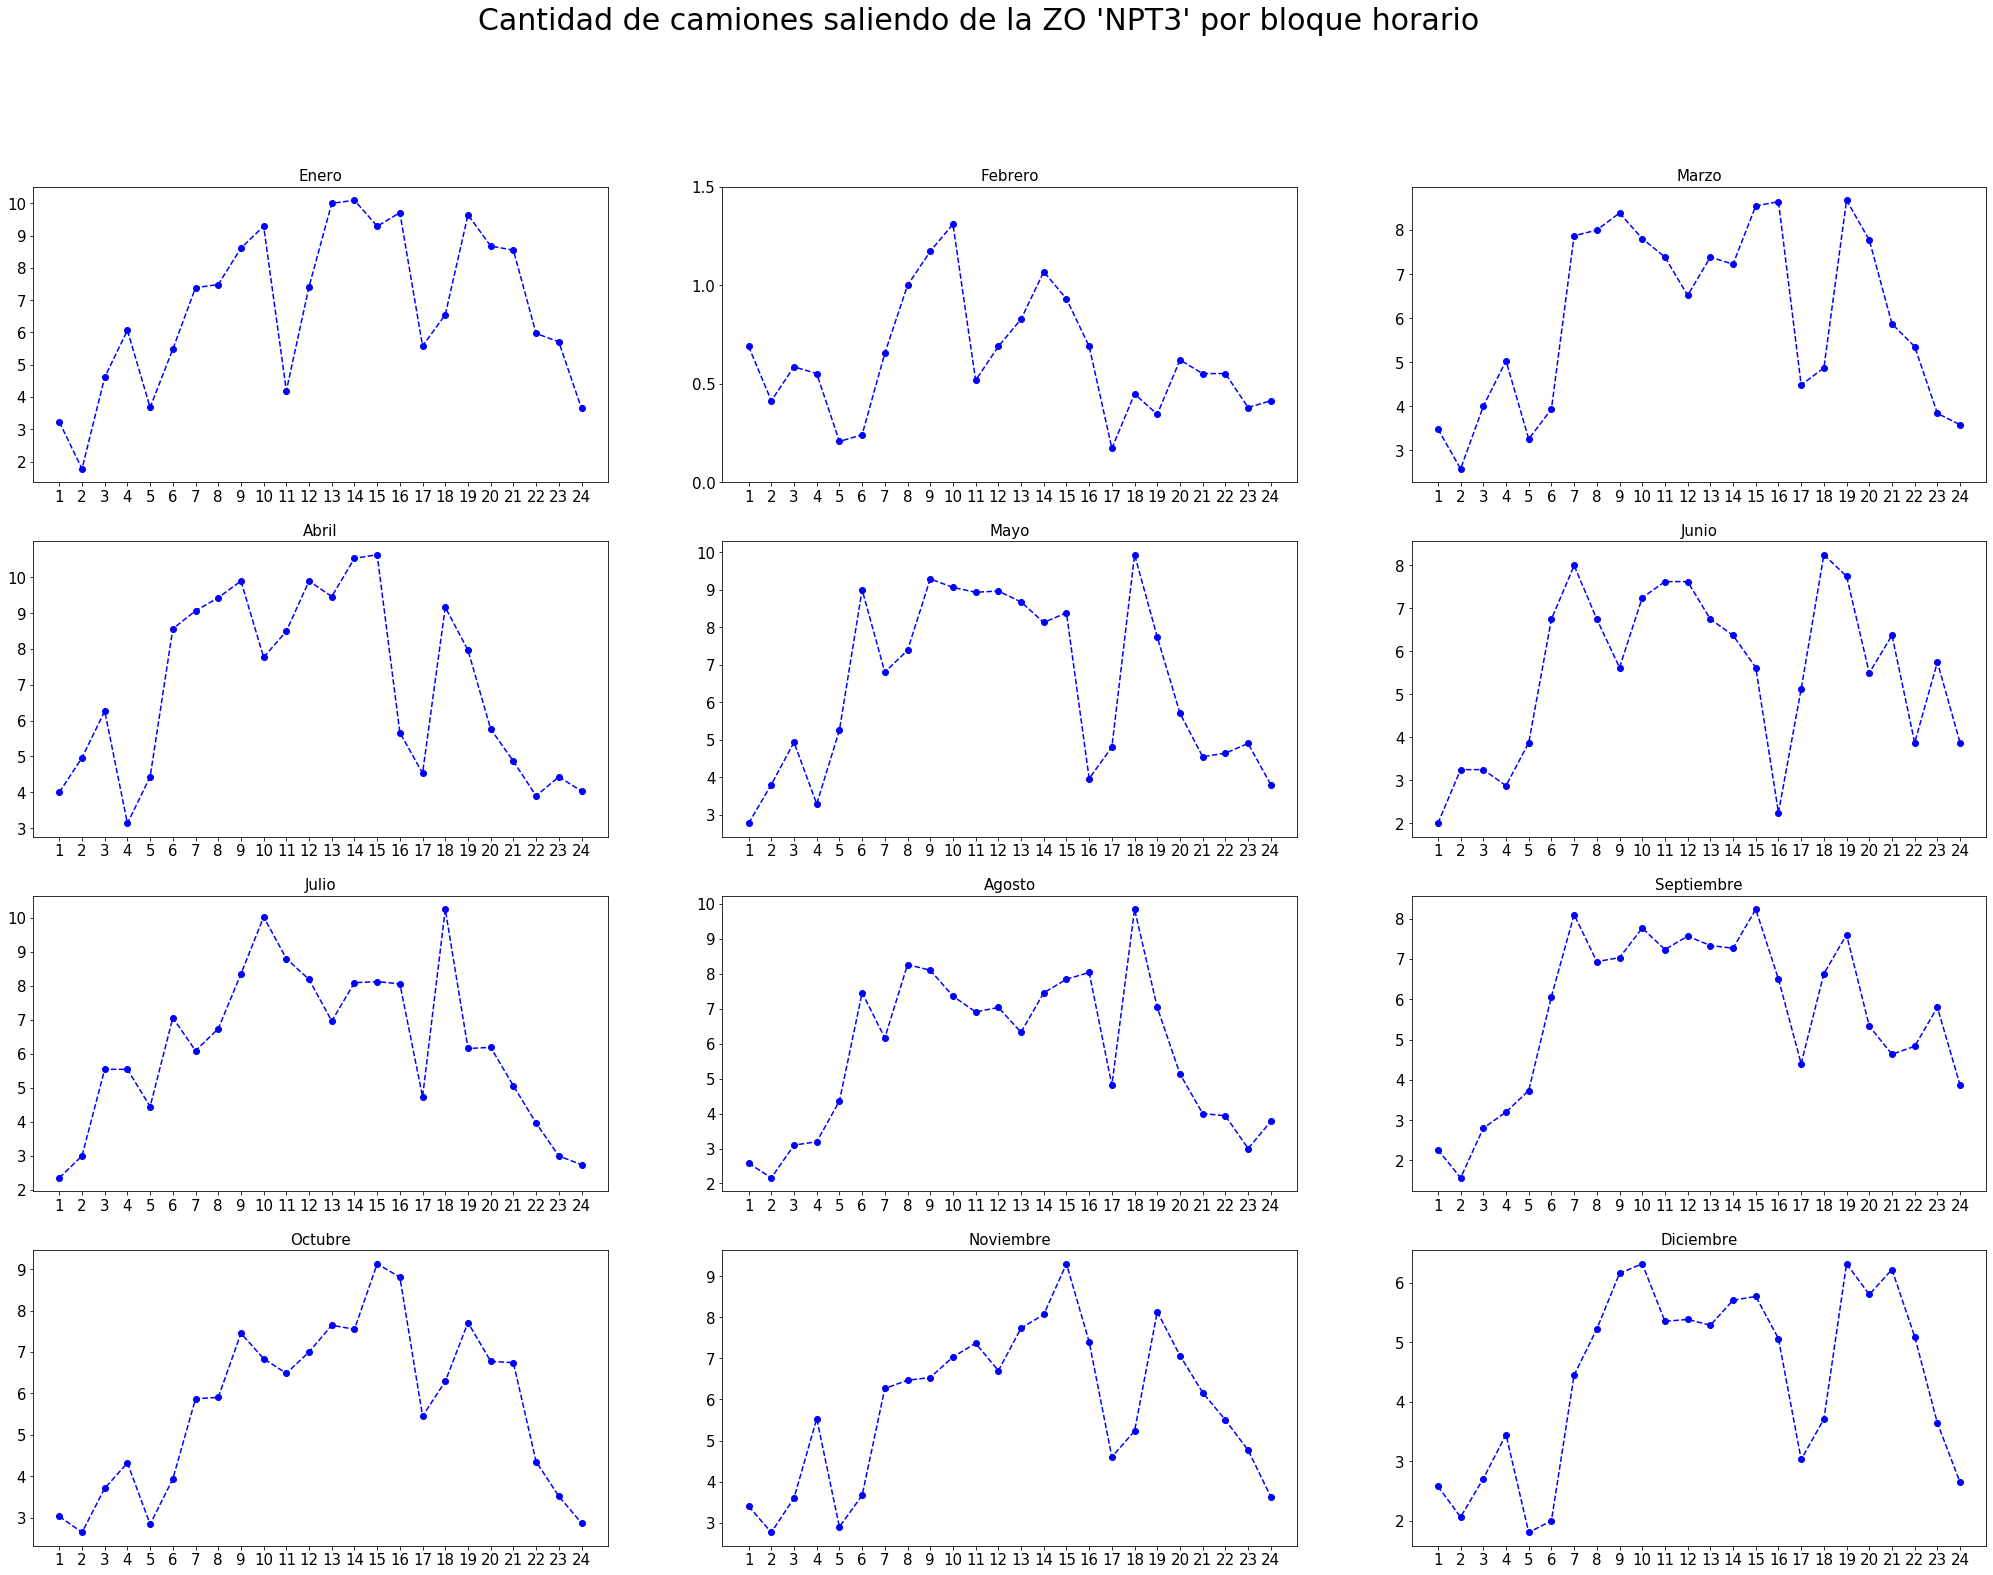

In [22]:
zone='C NPT3'
fig, axs = plt.subplots(4,3,figsize=(35,25))
fig.suptitle("Cantidad de camiones saliendo de la ZO 'NPT3' por bloque horario",fontsize =30)
plt.setp(axs, xticks=np.arange(1,25,1), yticks=np.arange(1,11,1))
#axs.tick_params(axis='both', which='major', labelsize=15)

axs[0,0].plot(Jan_n[zone],'bo--')
axs[0,0].set_title('Enero',fontsize=15)
axs[0,0].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[0,0].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[0,1].plot(Feb_n[zone],'bo--')
axs[0,1].set_title('Febrero',fontsize=15)
axs[0,1].set_yticks(np.arange(0,2,0.5))
axs[0,1].set_yticklabels(np.arange(0,2,0.5),fontsize=15)
axs[0,1].set_xticklabels(np.arange(1,25,1),fontsize=15)

axs[0,2].plot(Mar_n[zone],'bo--')
axs[0,2].set_title('Marzo',fontsize=15)
axs[0,2].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[0,2].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[1,0].plot(Apr_n[zone],'bo--')
axs[1,0].set_title('Abril',fontsize=15)
axs[1,0].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[1,0].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[1,1].plot(May_n[zone],'bo--')
axs[1,1].set_title('Mayo',fontsize=15)
axs[1,1].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[1,1].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[1,2].plot(Jun_n[zone],'bo--')
axs[1,2].set_title('Junio',fontsize=15)
axs[1,2].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[1,2].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[2,0].plot(July_n[zone],'bo--')
axs[2,0].set_title('Julio',fontsize=15)
axs[2,0].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[2,0].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[2,1].plot(Aug_n[zone],'bo--')
axs[2,1].set_title('Agosto',fontsize=15)
axs[2,1].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[2,1].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[2,2].plot(Sep_n[zone],'bo--')
axs[2,2].set_title('Septiembre',fontsize=15)
axs[2,2].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[2,2].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[3,0].plot(Oct_n[zone],'bo--')
axs[3,0].set_title('Octubre',fontsize=15)
axs[3,0].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[3,0].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[3,1].plot(Nov_n[zone],'bo--')
axs[3,1].set_title('Noviembre',fontsize=15)
axs[3,1].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[3,1].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[3,2].plot(Dec_n[zone],'bo--')
axs[3,2].set_title('Diciembre',fontsize=15)
axs[3,2].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[3,2].set_yticklabels(np.arange(1,11,1),fontsize=15)
plt.savefig("trucks_out_NPT3.jpg")
plt.show()


In [23]:
def graph_zone_month(zone):
    fig, axs = plt.subplots(4,3,figsize=(35,25))
    fig.suptitle("Cantidad de camiones saliendo de la ZO "+str(zone)+" por bloque horario",fontsize =30)
    plt.setp(axs, xticks=np.arange(1,25,1))
    #axs.tick_params(axis='both', which='major', labelsize=15)

    axs[0,0].plot(Jan_n[zone],'bo--')
    axs[0,0].set_title('Enero',fontsize=15)
    axs[0,0].set_xticklabels(np.arange(1,25,1),fontsize=15)
    #axs[0,0].set_yticklabels(np.arange(1,11,1),fontsize=15)

    axs[0,1].plot(Feb_n[zone],'bo--')
    axs[0,1].set_title('Febrero',fontsize=15)
    #axs[0,1].set_yticks(np.arange(0,2,0.5))
    #axs[0,1].set_yticklabels(np.arange(0,2,0.5),fontsize=15)
    axs[0,1].set_xticklabels(np.arange(1,25,1),fontsize=15)

    axs[0,2].plot(Mar_n[zone],'bo--')
    axs[0,2].set_title('Marzo',fontsize=15)
    axs[0,2].set_xticklabels(np.arange(1,25,1),fontsize=15)
    #axs[0,2].set_yticklabels(np.arange(1,11,1),fontsize=15)

    axs[1,0].plot(Apr_n[zone],'bo--')
    axs[1,0].set_title('Abril',fontsize=15)
    axs[1,0].set_xticklabels(np.arange(1,25,1),fontsize=15)
    #axs[1,0].set_yticklabels(np.arange(1,11,1),fontsize=15)

    axs[1,1].plot(May_n[zone],'bo--')
    axs[1,1].set_title('Mayo',fontsize=15)
    axs[1,1].set_xticklabels(np.arange(1,25,1),fontsize=15)
    #axs[1,1].set_yticklabels(np.arange(1,11,1),fontsize=15)

    axs[1,2].plot(Jun_n[zone],'bo--')
    axs[1,2].set_title('Junio',fontsize=15)
    axs[1,2].set_xticklabels(np.arange(1,25,1),fontsize=15)
    #axs[1,2].set_yticklabels(np.arange(1,11,1),fontsize=15)

    axs[2,0].plot(July_n[zone],'bo--')
    axs[2,0].set_title('Julio',fontsize=15)
    axs[2,0].set_xticklabels(np.arange(1,25,1),fontsize=15)
    #axs[2,0].set_yticklabels(np.arange(1,11,1),fontsize=15)

    axs[2,1].plot(Aug_n[zone],'bo--')
    axs[2,1].set_title('Agosto',fontsize=15)
    axs[2,1].set_xticklabels(np.arange(1,25,1),fontsize=15)
    #axs[2,1].set_yticklabels(np.arange(1,11,1),fontsize=15)

    axs[2,2].plot(Sep_n[zone],'bo--')
    axs[2,2].set_title('Septiembre',fontsize=15)
    axs[2,2].set_xticklabels(np.arange(1,25,1),fontsize=15)
    #axs[2,2].set_yticklabels(np.arange(1,11,1),fontsize=15)

    axs[3,0].plot(Oct_n[zone],'bo--')
    axs[3,0].set_title('Octubre',fontsize=15)
    axs[3,0].set_xticklabels(np.arange(1,25,1),fontsize=15)
    #axs[3,0].set_yticklabels(np.arange(1,11,1),fontsize=15)

    axs[3,1].plot(Nov_n[zone],'bo--')
    axs[3,1].set_title('Noviembre',fontsize=15)
    axs[3,1].set_xticklabels(np.arange(1,25,1),fontsize=15)
    #axs[3,1].set_yticklabels(np.arange(1,11,1),fontsize=15)

    axs[3,2].plot(Dec_n[zone],'bo--')
    axs[3,2].set_title('Diciembre',fontsize=15)
    axs[3,2].set_xticklabels(np.arange(1,25,1),fontsize=15)
    #axs[3,2].set_yticklabels(np.arange(1,11,1),fontsize=15)
    plt.savefig("trucks_out_"+str(zone)+".jpg")
    plt.close(fig)

    #plt.show()

In [24]:
columns = May.keys().tolist()
for keys in columns:
    if (keys == 'Romana 3' or keys == 'C PTS' or keys == 'C CS-12' or keys == 'C Granulacion' or keys == 'C CS-11' or keys == 'C CS-P.Valdivia'):
        continue
    print(keys)
    graph_zone_month(keys)

C NPT3
C Secado L-4
C CS-4
C ATM
C Prilado
C NPT4
Romana Salitre
Losa Envasado
Galpones
C NPT 1-2
Romana Mto
C Secado L-3


Nos faltaron los graficos de 6 zo, esto es debido a que seguramente en algun mes en particular no se encontró esta zona. Procederemos a realizar el grafico manualmente

# Analisis por maximos.

Por cada día dentro del mes realizaremos la generación de un data frame nuevo que contenga los maximos de esos 2 dataframes en cuestion.

In [ ]:
dias_mes = [[1,31],[32,60],[61,91],[92,121],[122,152],[153,160],[182,212],[213,243],[244,273],[274,304],[305,334],[335,365]]
#Enero
for i in range(dias_mes[0][0],dias_mes[0][1]+1):
    
    
M_Jan = dict_to_df(vehiculos(dias_mes[0][0],dias_mes[0][1],1,25,condition="out"))
M_Jan_n = M_Jan/(dias_mes[0][1]-dias_mes[0][0]+1) 
print("Enero")

In [1]:
zonas = ['C PTS','C NPT3','C NPT 1-2','C Granulacion','Salida','C Prilado','Romana Salitre','Romana Mto','C CS-4','C ATM',
         'Losa Envasado','C NPT4','C Secado L-4','Romana 3','C CS-12','Galpones','C CS-11']
len(zonas)

17